In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('슝=3')

2024-01-02 23:10:38.239769: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-02 23:10:38.350481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 23:10:38.350555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 23:10:38.364194: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 23:10:38.410241: I tensorflow/core/platform/cpu_feature_guar

슝=3


In [2]:
tf.config.list_physical_devices('GPU')

2024-01-02 23:10:41.046348: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-02 23:10:41.090374: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-02 23:10:41.090400: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

2024-01-02 23:10:41.121844: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-02 23:10:41.121896: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-02 23:10:41.121906: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-02 23:10:41.309884: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-02 23:10:41.309960: I external/local_xla/xla/stream_executor

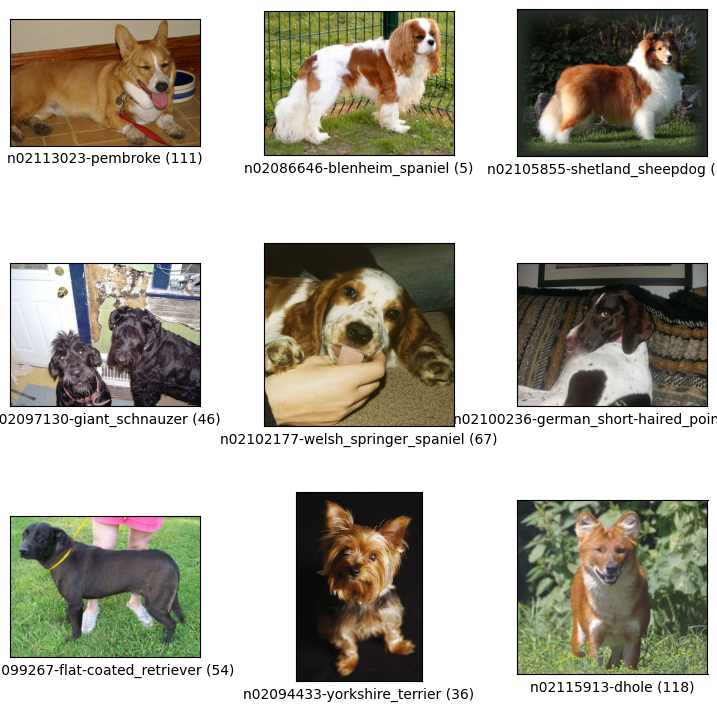

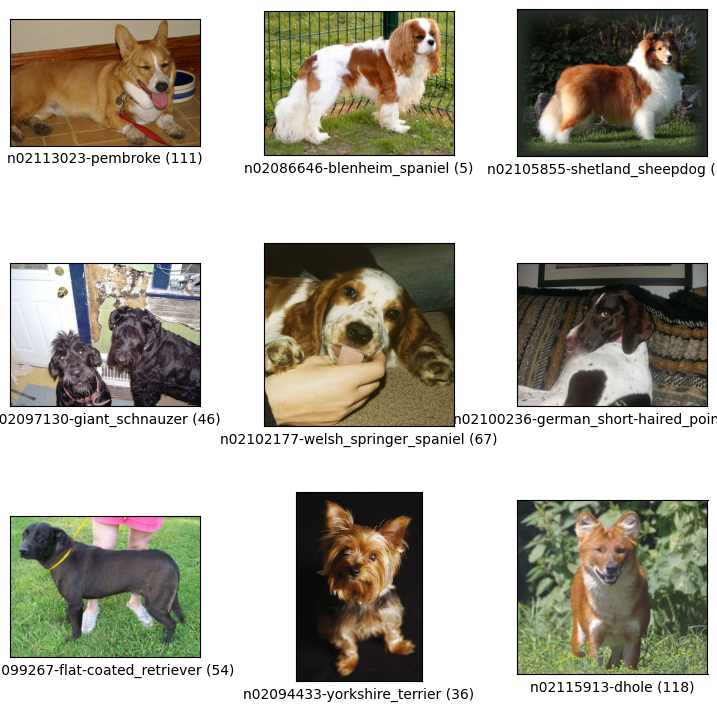

In [4]:
tfds.show_examples(ds_train, ds_info)

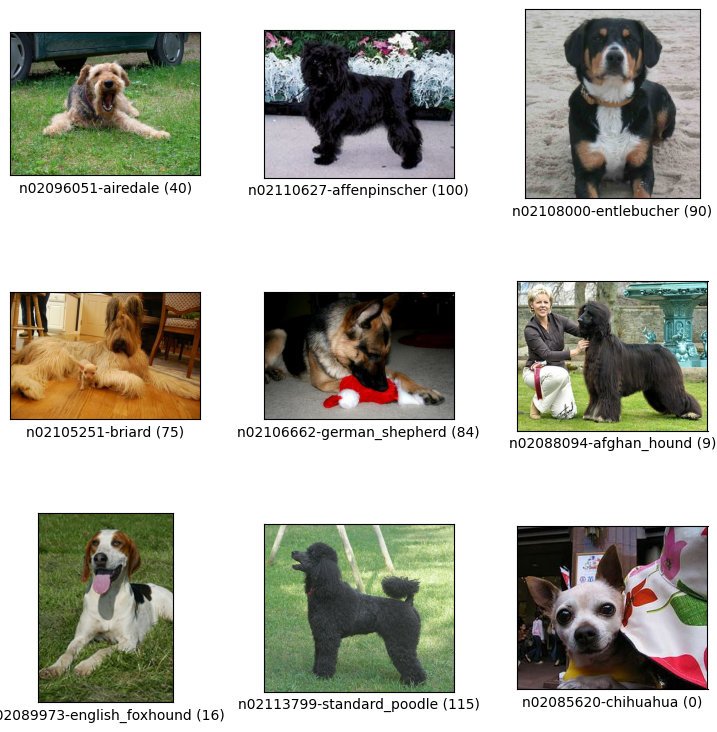

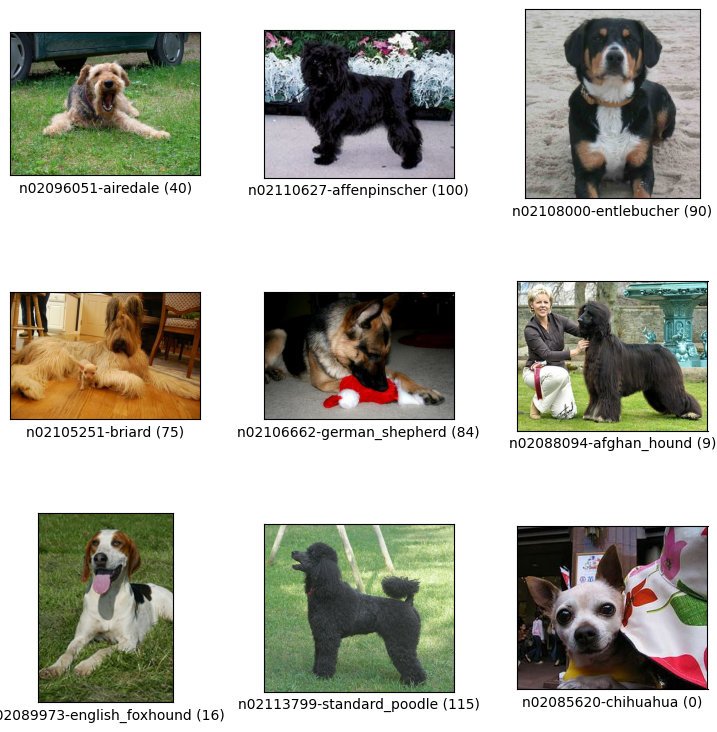

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x) 
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [9]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [10]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)


In [12]:
!pip install --upgrade aiffel7


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [13]:
import os


# 모델 학습
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/2


2024-01-02 23:10:53.956136: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-01-02 23:10:58.663753: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f7199f37530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-02 23:10:58.663776: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
I0000 00:00:1704204658.713515   87954 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


750/750 [==============================] - 106s 113ms/step - loss: 2.2382 - accuracy: 0.4411 - val_loss: 3.2052 - val_accuracy: 0.2220
Epoch 2/2
750/750 [==============================] - 85s 113ms/step - loss: 0.6476 - accuracy: 0.8276 - val_loss: 1.4073 - val_accuracy: 0.5989


In [14]:
import os

cam_model_path = 'cam_model1.h5'# 경로와 파일 이름을 결합

cam_model.save(cam_model_path)

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [16]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds



In [17]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]


108


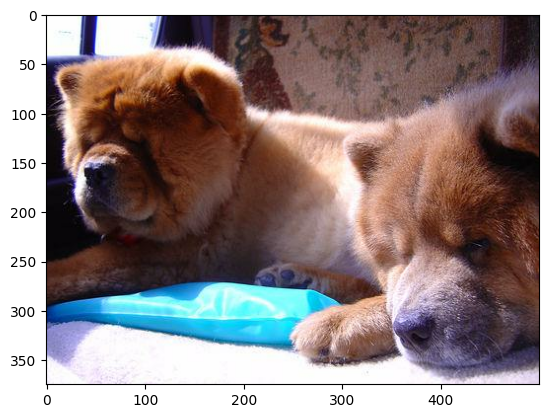

In [18]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [19]:
import os
cam_model_path = 'cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [20]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image


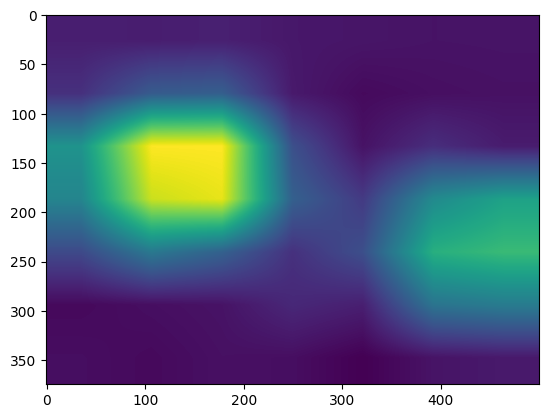

In [21]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [22]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

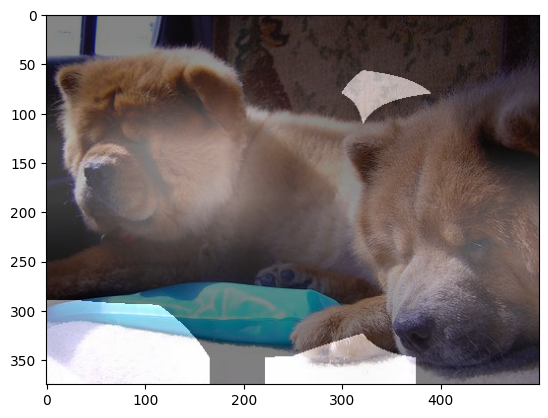

In [23]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

108


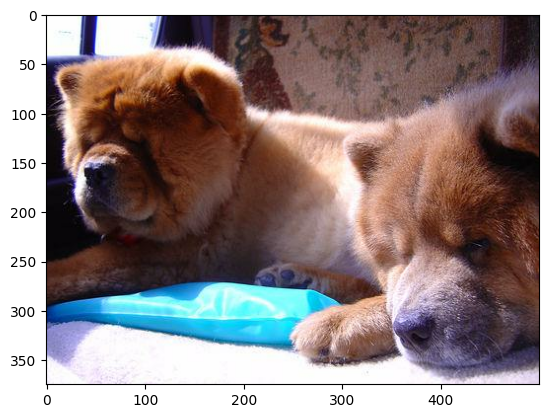

In [24]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [25]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('슝=3')

슝=3


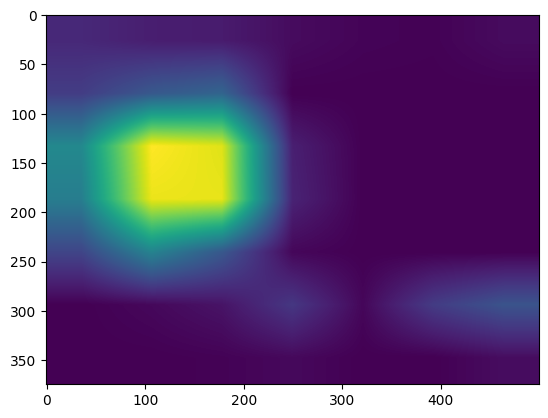

In [26]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

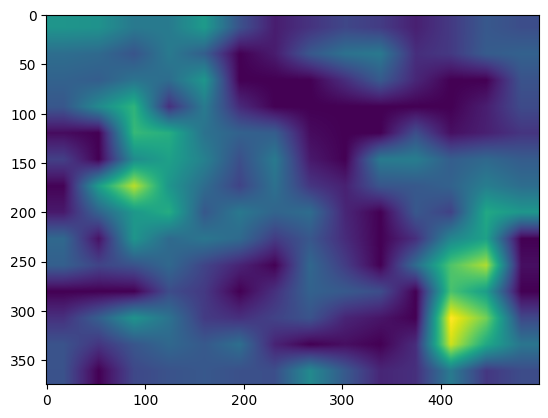

In [27]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

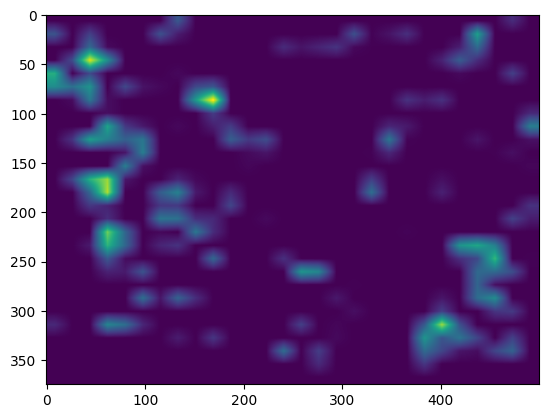

In [28]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

40


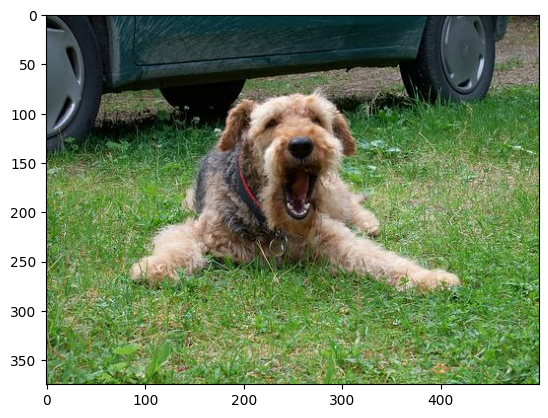

In [29]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

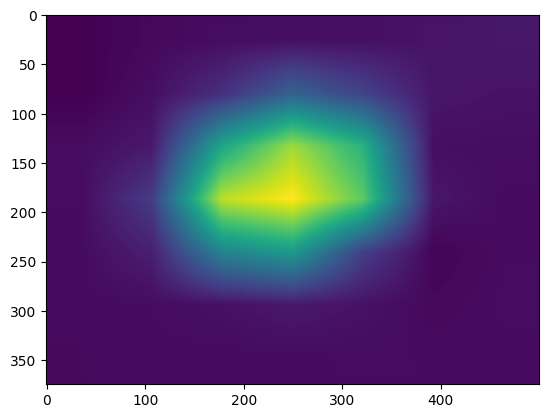

In [30]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [31]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('슝=3')

슝=3


In [32]:
rect = get_bbox(cam_image)
rect

/tmp/ipykernel_87749/3573549926.py:10: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  rect = np.int0(rect)


array([[ 59,  34],
       [390,  34],
       [390, 292],
       [ 59, 292]])

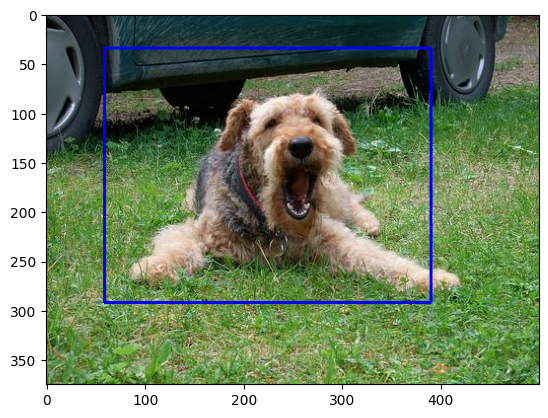

In [33]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [34]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print('슝=3')

슝=3


In [35]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.09066666666666667, 0.118, 0.7786666666666666, 0.78]

In [36]:
item['objects']['bbox'][0]

array([0.192, 0.168, 0.76 , 0.838], dtype=float32)

In [37]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('슝=3')

슝=3


In [38]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.7117444161729672